<a href="https://colab.research.google.com/github/mpompy/Neur265/blob/main/notebooks/Calcium_Imaging_04_08_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Calcium Imaging

In this notebook, we'll learn how calcium imaging works, how data are acquired, and how movies taken from microscopes are converted into fluorescent traces that can be correlated with behavior.

##By the end of this notebook, you will be able to:

- Plot locations of putative cells (regions of interest, or ROIs)
- Extract activity traces from these ROIs
- Cluster ROIs according to patterns of activity
- Correlate these patterns of activity with specific locations in the brain

##Introduction

Calcium imaging is a widely used technique in neuroscience research. Consider that, when recording action potentials from a tetrode or silicon probe, you are likely recording these action potentials from a variety of different "types" of neurons. One example of this would be *Sst* interneurons and *Pvalb* interneurons - which are all mixed in together in areas of cortex. A tetrode has no way of differentiating between these different types of neurons. To a tetrode, all action potentials are the same, and it will record action potentials from any neuron that is near it. To get around this problem, scientists engineered a protein, called "GCaMP", that fluoresces green (emits green fluorescent protein, or GFP) every time calcium enters a cell:

<img src = 'https://drive.google.com/uc?id=1ozU9-MZD2c2ChXShmESv7RPL8oiTiaGs'>

The genetic sequence that codes for GCaMP can be packaged into a virus, and injected into the brain. Remember from our earlier lectures that viruses can be used to target specific "types" of cells based on marker genes that those cells express. So, if we wanted to only look at *Pvalb* interneurons, we could make a virus that would only express GCaMP in neurons that also express *Pvalb*. Another advantage of calcium imaging is that we can *where* the neurons we image are located relative to each other - something that is impossible to do with tetrodes.

Once GCaMP is expressed in the brain, we need some way of imaging the fluorescence that occurs every time calcium enters the cell. Neuroscientists do this with microscopes - either 2-photon microscopes with "fixed" preparations (i.e., cells in a dish, or head-fixed animals):

<img src = 'https://drive.google.com/uc?id=1y9JvV780k1SCxQQjCP_lKBZHrU6Jf78W'>

Or with "miniscopes", which are 1-photon microscopes that can be attached to a lens that is surgically implanted into an animal's brain. The advantage of a miniscope is that the animal can move around during imaging, so that cellular responses can be correlated with some kind of behavior of interest:

<img src = 'https://drive.google.com/uc?id=1W78a2f9eesF3VaGs040rmCH579LUIiIc'>

In this notebook, we will be analyzing calcium imaging data from a light sheet microscope. These data were taken from zebrafish larvae expressing GCaMP in an area of the brain called the "pallium", a part of the telencephalic lobs in fish. We are interested to know if neurons in the pallium respond to a visual stimulus (LED), and if so, where in the pallium these neurons are located.

In [1]:
# Import relevant modules

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from skimage import io
from scipy.cluster.vq import vq, kmeans2
import matplotlib.patches as patches
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from random import seed

We have already isolated ROIs from our raw movie - the traces from these ROIs are stored in a .csv file called <code>zebrafish_traces.csv</code> on our GitHub repo. Import this file as a <code>pandas</code> dataframe called <code>zebrafish_traces</code> below:

In [3]:
# Import traces!

url='https://raw.githubusercontent.com/hallockh/neur_265/main/data/zebrafish_traces.csv'
zebrafish_traces=pd.read_csv(url)


There are many methods for extracting ROIs from raw imaging movies - all of these methods are time consuming and super computationally intensive! All of these methods extract "normalized fluorescence intesity" from movies - basically, the fluorescence emitted from GCaMP with fluorescent "noise" (background fluorescence) subracted from it. This background-normalized fluorescent signal is often called "$\Delta$F/F"

><b>Task:</b> Look at the first five rows of your <code>zebrafish_traces</code> dataframe. What are the columns? What do you think each column contains?

In [5]:
# Look at your dataframe!

zebrafish_traces.head(5)




,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1193,1194,1195,1196,1197,1198,1199,is_cell,x,y
0,0,0,0.000000,0.000000,0.000000,0.071112,0.137652,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,98,30
1,1,0,0.553788,0.294224,0.014636,0.000000,0.000000,0.0,0.000000,0.000000,...,0.002391,0.0,0.045775,0.009973,0.031753,0.028746,0.046584,1,105,129
2,2,0,0.409878,0.407646,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.030472,1,69,73
3,3,0,0.302192,0.379773,0.122698,0.000000,0.000000,0.0,0.000000,0.104660,...,0.000000,0.0,0.008454,0.000000,0.000000,0.060965,0.153083,1,53,95
4,4,0,0.106759,0.000000,0.000000,0.000000,0.147415,0.0,0.025876,0.049277,...,0.000000,0.0,0.000000,0.129580,0.040844,0.204923,0.020806,0,6,78


You should notice that there is a column called "<code>is_cell</code>", which contains a boolean indicating whether the extracted trace was identified as a cell or not (the algorithms that extract ROIs from raw images often make mistakes, and human intervention is needed to correctly separate noise from real signal). If we want to plot the traces in this dataframe, we should get rid of the rows that don't contain traces from cells:

In [6]:
# Gettin' rid of noise

cells = zebrafish_traces[zebrafish_traces['is_cell'] == 1]

To plot our traces, it would be easier also to export all columns that contain fluorescence data from the <code>is_cell</code> column and columns that contain x/y coordinates. Make a new variable below called <code>cells_activity</code> that contains all rows of <code>cells</code>, and columns 1:1201. Use the <code>.iloc</code> method from <code>pandas</code> to index the rows and columns you want:

In [8]:
# Put just the fluorescent traces into a new dataframe

cells_activity=cells.iloc[:, 1:1201]

print(cells_activity)


     0         1         2         3         4         5         6         7  \
1    0  0.553788  0.294224  0.014636  0.000000  0.000000  0.000000  0.000000   
2    0  0.409878  0.407646  0.000000  0.000000  0.000000  0.000000  0.000000   
3    0  0.302192  0.379773  0.122698  0.000000  0.000000  0.000000  0.000000   
5    0  0.000000  0.000000  0.000000  0.150107  0.193025  0.228785  0.000000   
6    0  0.000000  0.023594  0.000000  0.000000  0.000000  0.000000  0.000000   
..  ..       ...       ...       ...       ...       ...       ...       ...   
599  0  0.000000  0.000000  0.000000  0.007089  0.344106  0.071706  0.203196   
600  0  0.045415  0.102890  0.011803  0.094461  0.023187  0.000000  0.000000   
605  0  0.000000  0.000000  0.025828  0.000000  0.046945  0.113887  0.011648   
606  0  0.067010  0.000000  0.000000  0.041054  0.100013  0.000000  0.009123   
608  0  0.085476  0.069987  0.000000  0.000000  0.123540  0.000000  0.000000   

            8         9  ...      1190 

><b>Task:</b> Make a variable, <code>time</code>, that starts at "0", ends at the length of the recording session, and has a length equal to the number of samples in your <code>cells_activity</code> dataframe. The length of time between each sample in your <code>cells_activity</code> variable is equal to 3 s. Use this information to find the total length of the recording session, in seconds, and the microscope's frame rate (fps).

In [18]:
# Your code here!

time=np.linspace(0,3,1199)

length_recording_session=3*1199

frame_rate=1199/length_recording_session

print(length_recording_session)
print(frame_rate)







3597
0.3333333333333333


In [10]:
len(zebrafish_traces)

611

><b>Task:</b> Plot the first row of your <code>cells_activity</code> variable in <font color = 'blue'>blue</font>, and the second row of your <code>cells_activity</code> variable in <font color = 'red'>red</font>. Put time on the x-axis. Label your axes.

Text(0, 0.5, 'Florescent Intensity')

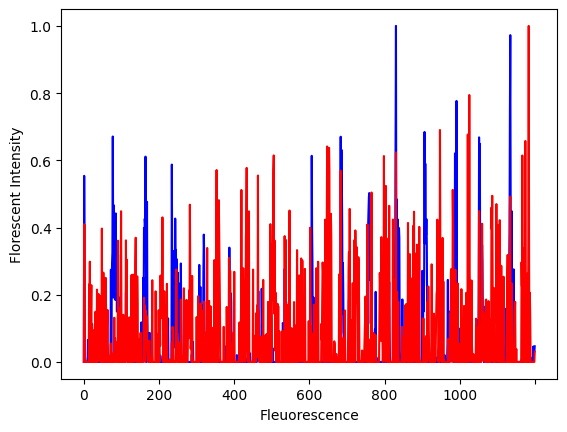

In [22]:
# Plot some traces!

cells_activity.iloc[0].plot(color='blue', label='row 1')
cells_activity.iloc[1].plot(color='red', label='row 2')

plt.xlabel('Fleuorescence')
plt.ylabel('Florescent Intensity')




The "<code>x</code>" and "<code>y</code>" columns of your <code>cells</code> dataframe contain coordinates for each ROI within the original imaging movie. These coordinates are useful for visualizing where each ROI was imaged from within the zebrafish pallium. We could use this information to answer questions like: Are cells with similar patterns of activity located more closely to one another?

><b>Task:</b> Create a scatter plot that displays the x and y coordinates from all cells in your <code>cells</code> dataframe.

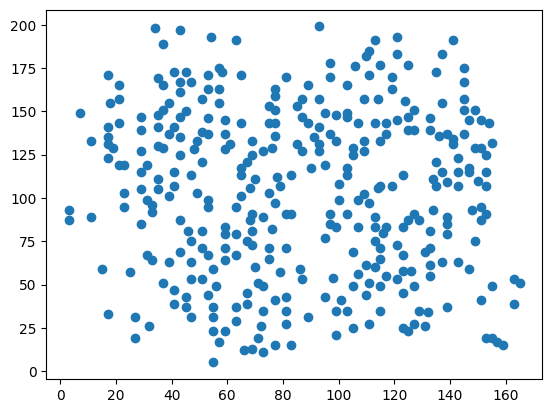

In [27]:
# Make a scatter plot!

plt.scatter(cells.iloc[:,-2], cells.iloc[:,-1])

Without seeing an image of the brain from our raw movie, it's hard to interpret the scatter plot above. We can overlay the x/y coordinates on top of such an image to get a better understanding of where each ROI was located in the pallium. To do this, we need to import this image from our GitHub repo:

In [30]:
# Import a raw image

!git clone https://github.com/hallockh/neur_265.git images
from PIL import Image
img_fname = 'images/data/zebrafish_image.tif'


fatal: destination path 'images' already exists and is not an empty directory.


Let's also plot the raw traces next to the image. To do this, we'll need to scale our traces to values between "0" and "1" so that they can all fit together on the same plot. Let's make a quick function that will do this:

In [31]:
# Scalin' traces

def norm(f):
    return (f - np.min(f))/np.max(f - np.min(f))

Now, let's plot our data:

ValueError: x and y must have same first dimension, but have shapes (1197,) and (1198,)

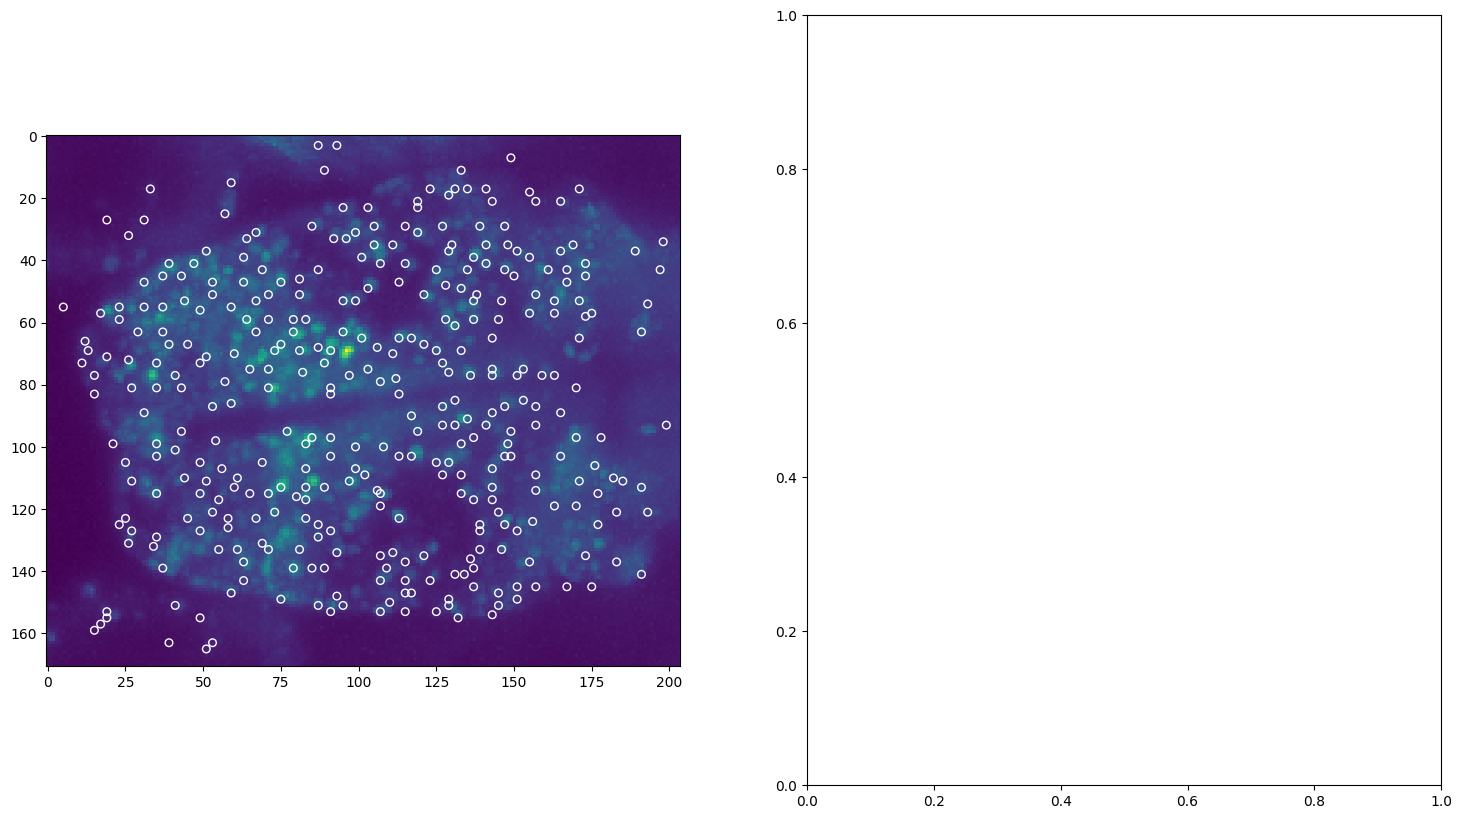

In [38]:
secPerFrame = 3; # time between frames
plt.figure(figsize=(18,10))

ax1 = plt.subplot(1,2,2)
ax2 = plt.subplot(1,2,1)

xs,ys = [cells.x, cells.y]
# show original data image
plt.imshow(io.imread(img_fname))
# plot locations of cells as open circles
plt.scatter(ys, xs, s=30,facecolors='none',edgecolors='w')

# select "first" 20 cells
cell_ids = range(20)

# or select random 20 cells from all the cells, replace=False means that there will be no repetitions
#cell_ids = np.random.choice(range(len(cells)), 20, replace=False)

for cell_i in range(len(cell_ids)):
    plt.subplot(1,2,2)
    plt.plot(time[2:], norm(cells_activity.iloc[cell_ids[cell_i],2:]) + cell_i ,'k')
    plt.subplot(1,2,1)
    plt.text(ys.iloc[cell_ids[cell_i]], xs.iloc[cell_ids[cell_i]], cell_i,fontsize=15,color='w',weight='bold')

ax1.set_yticks(range(len(cell_ids)))
ax1.set_ylabel('Cell ID')
ax1.set_xlabel('Time, sec')

ax1.set_aspect(np.max(time) / len(cell_ids))
ax2.set_aspect(1)

plt.subplot(1,2,1)
cb = plt.colorbar( fraction=0.039, pad=0.03);  # magic numbers fraction & pad to set up proper size of the colorbar
cb.set_label('Fluorescence, a.u.')
plt.show()


Question: Look at the traces on the right, and see if you can identify some that seem to have similar patterns of activity. Do these traces seem to come from cells (ROIs) that are located in the same area of the pallium?

><b>Task:</b> Un-comment the line that makes your <code>cell_ids</code> variable equal to randomly-picked traces, and re-make your plot. Which traces did you get? Do you notice any relationships between function and spatial location in these cells?

From looking at our raw traces, we might notice that it seems like some traces have similar patterns of activity - for example, cells "3" and "7" seem like they both have irregular patterns of fluorescence across time, while cells "0" and "2" seem like they have regular "bursts" of fluorescence that are equally spaced apart. Instead of relating each individual trace to a spatial location on our image, it might instead be useful to try and cluster traces that have similar patterns of activity together, and see how these clusters map onto our image. To do this, we can use a technique called ["K-means clustering"]('https://en.wikipedia.org/wiki/K-means_clustering') - a method that creates *n* clusters based on variance in a dataset, and attempts to assign each datapoint (in this case, each ROI) to a given cluster based on proximity of that datapoint to the cluster's mean.

Before we do this, it might be helpful to view all of the ROIs in our dataset as a heatmap to more clearly identify any similar patterns of activity that might exist:

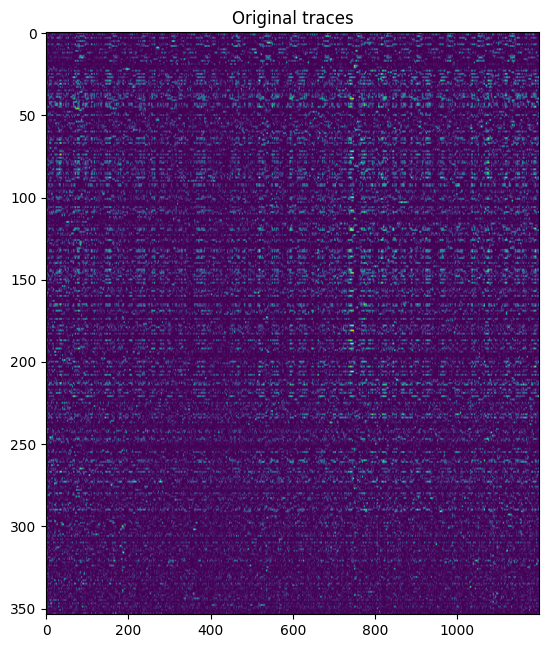

In [33]:
# Plot original traces as a heatmap

data_t = np.asarray(cells_activity.iloc[:,:]);

plt.figure(figsize=(14,14))
ax1 = plt.subplot(1,2,1)
plt.imshow(data_t)
ax1.set_aspect(4)
plt.title('Original traces');

Question: Do you notice any ROIs that seem to have similar patterns of activity? How many clusters of similar ROIs do you think there might be in the data?

Let's now apply K-means clustering to the data, and see what we get:

<ipython-input-34-3c30a15d3dcc>:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('terrain', Ks)


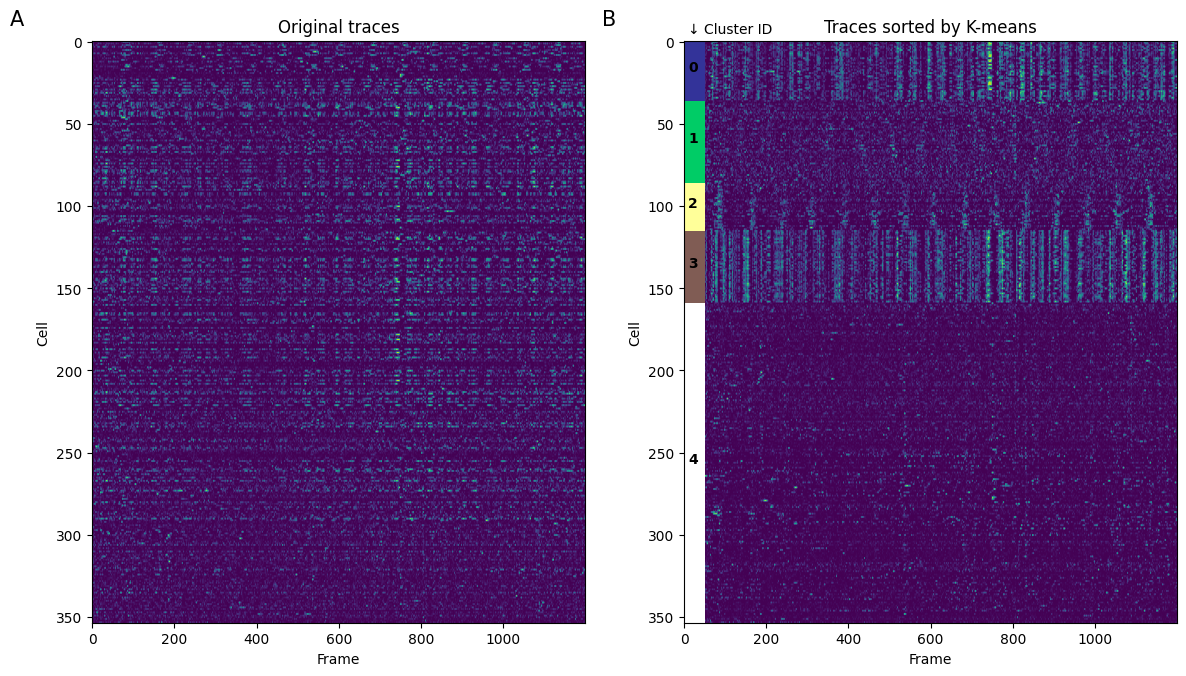

In [34]:
# Apply K-means clustering

data_t = np.asarray(cells_activity.iloc[:,:]);

plt.figure(figsize=(14,14))
ax1 = plt.subplot(1,2,1)
plt.imshow(data_t)
ax1.set_aspect(4)
plt.title('Original traces');

ax2 = plt.subplot(1,2,2)

Ks = 5
# K-means relies on random number generation, we can fix the seed to have same result each time
centroid, labels = kmeans2(data_t, Ks, seed=1111111)

# argsort outputs indeces after sorting the argument
# so i_labels contains indeces of cells, sorted by corresponding cluster ID
i_labels = np.argsort(labels)

plt.imshow(data_t[i_labels,:])
ax2.set_aspect(4)
plt.title('Traces sorted by K-means');

cmap = cm.get_cmap('terrain', Ks)

# Cosmetic code to create a Rectangle patches to label specific K-cluster
Koffset = 0
for Ki in range(Ks):
    Nk = np.size(np.where(labels == Ki))
    # 40 is width of the rectangle
    rect = patches.Rectangle((0, Koffset), 50, Nk, linewidth=1, edgecolor='none', facecolor=cmap(Ki))
    ax2.text( 10, Koffset + Nk/2, Ki ,color='k', weight='bold')
    # Add the patch to the plot
    ax2.add_patch(rect)
    Koffset += Nk

ax2.text(10,-5,'↓ Cluster ID',fontsize=10)


# add subplot labels
ax1.text(-200,-10,'A',fontsize=15)
ax2.text(-200,-10,'B',fontsize=15)

ax1.set_xlabel('Frame')
ax2.set_xlabel('Frame')

ax1.set_ylabel('Cell')
ax2.set_ylabel('Cell')




plt.show()

Question: Notice that we defined the number of clusters that we wanted before applying the algorithm. Do you think that this number of clusters is appropriate? Try re-running the algorithm with 4 clusters, and again with 6. What do you notice?

We want to know how these clusters might map onto spatial location in the pallium. To do this, we'll need to plot our clusters on top of our zebrafish image.

In [ ]:
# plot locations of ROIs color-coded by cluster
plt.figure(figsize=(10,10))

# show original data image
# comment it if the image is too busy, but it will require adjusting legend position since imshow flips Y axis
plt.imshow(io.imread(img_fname)) # †

# use same colormap as rectangles from raster plot
# each color represents one cluster
plt.scatter(ys, xs, 100, c = labels, cmap=cmap, edgecolors='k', linewidth=1)

# remove ticks
ax = plt.gca();
ax.set_xticklabels([])
ax.set_yticklabels([])

# add cluster legend
for Ki in range(Ks):
    # create rectangle
    rect = patches.Rectangle((5, Ki*6+8), 10, 5, linewidth=1, edgecolor='k', facecolor=cmap(Ki))
    # add text with cluster number
    ax.text( 5+4, Ki*6+8+4, Ki ,color=('w' if Ki==0 else 'k'), weight='bold')
    # Note: we use white color for cluster 0 due to better visibility
    # see https://en.wikipedia.org/wiki/%3F:#Python for syntax

    # Add the patch to the plot
    ax.add_patch(rect)

# uncomment if you are not using imshow() above (†)
# plt.gca().invert_yaxis()

ax.text(1, 4, 'Clusters:', color='w', weight='bold')
plt.show()

Question: Does there seem to be any anatomical organization to the clusters? How does each cluster map to distinct areas of the zebrafish brain?

Let's also plot the average fluorescent trace from each cluster below:

In [ ]:
f = plt.figure(figsize=(20,5))
plt.subplot(121)

for Ki in range(0,Ks):
    # find indeces of traces where cluster label equals to Ki
    js = np.where(labels == Ki);
    # calculate average activity trace for cluster Ki
    d  = np.mean(np.squeeze(data_t[js, :]), axis=0);
    # normalize so that each trace is between 0 and 1
    d  = norm(d);
    plt.plot(d+Ki)

p = plt.gca();
p.set_ylabel('Cluster ID', fontsize=15)
p.set_xlabel('Frame', fontsize=15)
p.set_title('Average activity of each cluster', fontsize=20)

# add subplot label for figure
plt.text(-200,5.5,'A',fontsize=20)


plt.subplot(122)

K0 = 2;
iis = np.where(labels == K0)[0];
m = np.mean(data_t[iis,:], 0)
s = np.std(data_t[iis,:], 0)
ts = range(0,1200)
plt.plot(m,'-k')
# create fill between mean-std and mean+std, fill with grey color
plt.fill_between(ts, m-s, m+s, alpha=0.4, color=(0.1,0.1,0.1))
p = plt.gca();

# Here we use LaTeX symbol for plus/minus sign
p.set_title('Average activity of Cluster #' +str(K0)+  ' (mean $\pm$ std)', fontsize=20)
p.set_xlabel('Frame', fontsize=15)
p.set_ylabel('Activity, a.u.', fontsize=15)

p.legend(('mean','std'), fontsize=15)
plt.text(-200,0.8,'B',fontsize=20)
plt.show();

It seems like these 5 clusters do a good job of representing the variation in activity across all ROIs.
